### Laplace Mechanism for Differential Privacy

Here we construct the basic building blocks for a Laplace mechanism, a random sampler from the distribution, a clamp/clip/censor function, the function for the true mean, and then the DP release algorithm itself.

In [1]:
import numpy as np

def laplace(shift=0., scale=1., size=None):
    """Sample from the laplace distribution."""
    p = np.random.uniform(low=-0.5, high=0.5, size=size)
    draws = shift - scale * np.sign(p) * np.log(1 - 2 * abs(p))
    return draws

    # the easy way
    # return np.random.laplace(loc=shift, scale=scale, size=size)


def clamp(x, bounds):
    """Replace any x_i less than lower with lower, 
           and any x_i greater than upper with upper."""
    lower, upper = bounds
    x_clamped = x.copy()
    x_clamped[x<x_clamped] = lower
    x_clamped[x>x_clamped] = upper
    return x_clamped

    # the easy way
    # return np.clip(x, *bounds)


def bounded_mean(x, bounds):
    lower = min(x)
    upper = max(x)
    bounds = (lower, upper)

    x_clamped = clamp(x, bounds)
    bounded_mean = np.mean(x_clamped)
    return bounded_mean

    # the easy way
    # return np.mean(clamp(x,bounds))


def release_dp_mean(x, bounds, epsilon):
    """Release a DP mean. 
    Assumes that the dataset size n is public information.
    """

    # privatize
    n = len(x)
    lower, upper = bounds
    sensitivity = something here
    scale = something here
    
    dp_mean = something here
    return dp_mean

    # the compact way
    # return laplace(shift=mean(x_clamped(x)), scale=(upper-lower)/(n*epsilon))
    

Read in the data.  We're going to use the PUMS dataset we are familiar with, and focus on the education variable, a 16 point scale.

In [2]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

# define public information
n = len(data)            # in this case, dataset length is considered public, and is not protected
educ_bounds = (1., 16.)  # easily guessable without looking at the data

educ = data['educ'].values.astype(float)
print(release_dp_mean(educ, bounds=educ_bounds, epsilon=1.))

10.608674517357178


Now that we have a mechanism available, let's try a new one, the histogram.  Histograms give counts of the number of observations within defined partitions of the variable domain.  Consider carefully the sensitivity for the histogram, which depends on which definition of neighbouring we are using.

In [3]:
def release_histogram(x, epsilon, categories):
    sensitivity = something here
    scale = something here
    
    # sensitive_histogram = np.histogram(x, bins=categories)[0]  # [0] is counts [1] is bins

    # create a {category: count} hashmap
    counts = dict(zip(*np.unique(x, return_counts=True)))
    # look up the count of each category, or zero if not exists
    sensitive_histogram = np.array([counts.get(cat, 0) for cat in categories])

    dp_histogram = something here
    return dp_histogram


Let's call our privacy-preserving histogram.

In [4]:
educ_categories = list(range(1, 17))
output = release_histogram(educ, epsilon=1., categories=educ_categories)

print(output)

[ 274.27504817  137.54720022  359.31917592  471.21267774  500.62950321
  757.2251662   892.53079748 1051.79452552 5148.26777801 1393.54647601
 3964.41066181 1162.07367164 6285.39639406 2265.18144374  796.68306727
  309.19641575]


We're going to simulate repeated draws from the Laplace mechanism to examine the utility it offers over the range of epsilon values and dataset sizes, for our education variable.  

We'll need a way to construct new datasets, given we only have one available.  The (nonparametric) bootstrap function lets us construct datasets even larger than our original source data if needed, by treating the sample data as if it is a population from which we can resample.

In [5]:
import math

def bootstrap(x, n):
    """Sample n values with replacement from n."""
    index = np.random.randint(low=0., high=len(x), size=n)
    return x[index]

    # the easy way
    # return np.random.choice(x, size=n)


n_sims = 10

log_seq = np.linspace(start=math.log10(200), stop=math.log10(1500), num=15)
n_seq = (10**log_seq).astype(int)
print(n_seq)


log_seq = np.linspace(start=math.log10(1), stop=math.log10(0.1), num=5)
ep_seq = (10**log_seq *100).astype(int)/100
print(ep_seq)

agg_history = []

aggcount = 0

for i, n_sim in enumerate(n_seq):
    for j, epsilon_sim in enumerate(ep_seq):
        sq_error = 0

        for k in range(n_sims):
            bootdata = bootstrap(educ, n_sim)
            sensitive_mean = bounded_mean(x=bootdata, bounds=educ_bounds)
            dp_mean = release_dp_mean(x=bootdata, bounds=educ_bounds, epsilon=epsilon_sim)
            sq_error += (dp_mean - sensitive_mean) ** 2

        agg_history.append([
            n_sim,
            epsilon_sim,
            np.sqrt(sq_error/n_sims)  #RMSE
        ])
        
        aggcount += 1

agg_history = pd.DataFrame(agg_history, columns=["N", "epsilon", "error"])


[ 200  230  266  307  355  410  474  547  632  730  843  974 1124 1298
 1500]
[1.   0.56 0.31 0.17 0.1 ]


Graphing our results is often a case of finding an approximate template and then tweaking it to convey the exact details of interest to your reader.  This template for showing the utility of DP releases will likely be commonly useful across your homeworks and project.

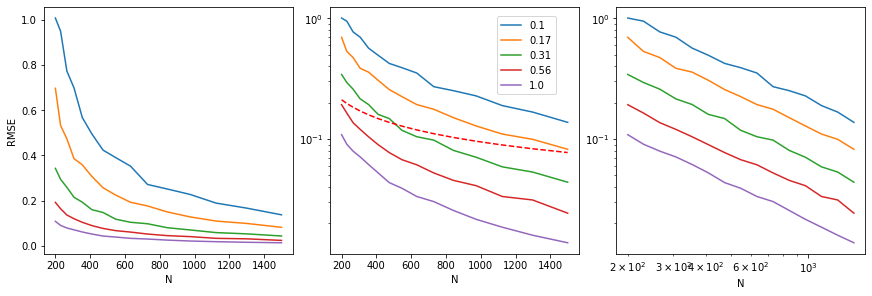

In [19]:

import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(12,4), layout='constrained')

axs[0].set_ylabel("RMSE")
axs[1].set_yscale("log")
axs[2].set_xscale("log")
axs[2].set_yscale("log")

for epsilon_sim, subhistory in agg_history.groupby("epsilon"):
    for ax in axs:
        subhistory.plot(x="N", y="error", label=epsilon_sim, ax=ax, legend=None)

## Overlay the standard error of the mean
#se = np.std(educ) / np.sqrt(n_seq)
#axs[1].plot(n_seq, se, linestyle='dashed', color="red")

_ = fig.legend(*axs[0].get_legend_handles_labels(), loc=(0.57, 0.68))


### OpenDP

The OpenDP Project is a community effort to build trustworthy, open source software tools for analysis of private data. The core software of the OpenDP Project is the OpenDP Library.

The OpenDP Library is a modular collection of statistical algorithms that adhere to differential privacy. The library is based on a conceptual framework described in [A Programming Framework for OpenDP](https://projects.iq.harvard.edu/files/opendp/files/opendp_programming_framework_11may2020_1_01.pdf).

The OpenDP Library can be found on GitHub: https://github.com/opendp/opendp/

In [7]:
from opendp.meas import *
from opendp.trans import *
from opendp.typing import *
from opendp.mod import enable_features, Transformation, Measurement
enable_features("contrib", "floating-point")

OpenDP represents computations with Transformations and Measurements.

In [8]:
# create a measurement that simply adds laplace noise
scale = 0.5
base_laplace: Measurement = make_base_laplace(scale=scale)

# call the measurement like a function
base_laplace(arg=23.)

23.114950496488117

In [9]:
# create a mean transformation
sized_bounded_mean: Transformation = make_sized_bounded_mean(size=n, bounds=educ_bounds)

# call the transformation like a function
sized_bounded_mean(arg=educ)

10.608553908251183

We can also _chain_ transformations and measurements. You might already think of chaining as function composition. The reason why we call it "chaining," instead of "composition," is because composition has a special meaning in differential privacy. In the context of differential privacy, composition refers to the joint release of more than one measurement.

In [10]:
# chain with the base_laplace measurement
dp_mean: Measurement = sized_bounded_mean >> base_laplace

# release a dp mean
dp_mean(arg=educ)

10.090138755210502

Now that we've shown how to build up computations and execute them, lets talk about distances.

Transformations and Measurements relate distances. There are three kinds of distances:

1. Dataset distances  
    (greatest distance between neighboring datasets)
1. Sensitivities  
    (greatest distance between queries on neighboring datasets)
1. Privacy budget    
    (greatest distance between the probability distributions)

The following shows how the `base_laplace` measurement relates a `sensitivity` to a privacy budget, `epsilon`.


In [11]:
# Check that when sensitivity is 0.15, the privacy usage is .30
base_laplace.check(d_in=.15, d_out=.30)

True

We can interpret this as: If the sensitivity is .15, then we could release the query answer with `laplace(scale=.5)` noise at a privacy expenditure of `.3 epsilon`. Equivalently, this data release is `.3 differentially private`, or `.3-DP`, where the privacy units are implicitly in terms of epsilon.

If we were to increase the sensitivity, the same relation would fail, and the release would not be `.3-DP`.

In [12]:
base_laplace.check(d_in=.16, d_out=.3)

False

As you might expect, the relation will also pass for any sensitivity that is smaller, or any privacy expenditure that is larger. 

In [13]:
print(base_laplace.check(d_in=.15, d_out=.31))
print(base_laplace.check(d_in=.14, d_out=.30))

True
True


Similarly, the `sized_bounded_mean` transformation relates a dataset distance `max_influence` to a `sensitivity`.

In [14]:
max_influence = 1 # the greatest number of records that an individual can influence
sized_bounded_mean.check(d_in=max_influence, d_out=.15)

True

You can also relate distances on chained computations. The units for the input and output distances come from the constituent transformations and measurements. 

For example, when we chain the `sized_bounded_mean` transformation and `base_laplace` measurement together, the input distance is a dataset distance, `max_influence`, and the output distance is measured in terms of a privacy budget, `epsilon`.

In [15]:
# Check that when neighboring datasets differ by at most one record, the privacy usage is .3
dp_mean.check(d_in=1, d_out=.3)

True

The `release_histogram` function behaves similarly to the `make_count_by_categories` function in OpenDP.

In [16]:
help(make_count_by_categories)

Help on function make_count_by_categories in module opendp.trans:

make_count_by_categories(categories: Any, MO: opendp.typing.SensitivityMetric = 'L1Distance<i32>', TIA: Union[ForwardRef('RuntimeType'), _GenericAlias, str, Type[Union[List, Tuple, int, float, str, bool]], tuple] = None, TOA: Union[ForwardRef('RuntimeType'), _GenericAlias, str, Type[Union[List, Tuple, int, float, str, bool]], tuple] = 'i32') -> opendp.mod.Transformation
    Make a Transformation that computes the number of times each category appears in the data. 
    This assumes that the category set is known.
    
    :param categories: The set of categories to compute counts for.
    :type categories: Any
    :param MO: output sensitivity metric
    :type MO: SensitivityMetric
    :param TIA: categorical/hashable input type. Input data must be Vec<TIA>.
    :type TIA: RuntimeTypeDescriptor
    :param TOA: express counts in terms of this numeric type
    :type TOA: RuntimeTypeDescriptor
    :return: A count_by_catego

In [17]:
# release a histogram with laplace noise
dp_histogram_laplace = (
    make_count_by_categories(categories=educ_categories, TOA=float, MO=L1Distance[float]) >>
    make_base_laplace(scale=1., D=VectorDomain[AllDomain[float]])
)
dp_histogram_laplace(educ.astype(np.int32))


[274.0585007589752,
 143.01135804534235,
 357.6583353225793,
 468.61412928863473,
 497.27259971701176,
 756.9792458708657,
 893.4564041374473,
 1061.015511634635,
 5146.801877612312,
 1398.0194930896066,
 3963.904782151356,
 1159.1778959673352,
 6283.520282016287,
 2268.090617861308,
 794.3033770310691,
 311.48354413102135,
 -0.8852487747559074]

In practice, it's more secure to chain with the geometric mechanism:

In [18]:
# release a histogram with geometric noise
dp_histogram_geometric = (
    make_count_by_categories(categories=educ_categories) >>
    make_base_geometric(scale=1., D=VectorDomain[AllDomain[int]])
)
dp_histogram_geometric(educ.astype(np.int32))

[272,
 143,
 355,
 470,
 496,
 756,
 894,
 1057,
 5146,
 1393,
 3965,
 1155,
 6280,
 2269,
 793,
 308,
 0]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0df97151-1c38-49bc-a037-2a058b96fd82' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>